In [84]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import glob
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# Personal
import hscUtils as hUtil
#import galSBP
import coaddCutoutGalfitSimple as gSimple 

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

import emcee
import corner

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

## Constants
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.15, 0.64
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.20, height]
SBP1 = [0.124, 0.085, 0.865, 0.33]
SBP2 = [0.124, 0.41, 0.865, 0.55]
EC1 = [0.135, 0.072, 0.862, 0.295]
EC2 = [0.135, 0.366, 0.862, 0.295]
EC3 = [0.135, 0.666, 0.862, 0.295]
REC = [0.12, 0.11, 0.87, 0.87]
COG1 = [0.143, 0.10, 0.850, 0.43]
COG2 = [0.143, 0.53, 0.850, 0.43]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
RR50_COMMON = np.arange(0.0, 9.0, 0.01)
EMPTY = (RSMA_COMMON * np.nan)

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# 3-sigma
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

import seaborn as sns
sns.set(color_codes=True)

# Location and Files

In [3]:
# Location of the data
homeDir = os.getenv('HOME')
synpipeDir = os.path.join(homeDir, 'astro4/synpipe/')
sampleDir = os.path.join(synpipeDir, 'sample/cosmos')

# Samples
cosPhoFile = os.path.join(sampleDir, 'cosmos_mag25.2_shuang_photo.fits')
cosHscFile = os.path.join(sampleDir, 'cosmos_mag25.2_shuang_photo_hscmatch.fits')

cosPho = Table.read(cosPhoFile, format='fits')
cosHsc = Table.read(cosHscFile, format='fits')

# Outputs 
outDir = os.path.join(synpipeDir, 'outputs')
starDir = os.path.join(outDir, 'star')
galaxyDir = os.path.join(outDir, 'galaxy')

## Test outputs for stars

In [6]:
glob.glob(starDir + '/*.fits')

['/Users/song/astro4/synpipe/outputs/star/star1_HSC-G_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-G_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-I_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-I_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-R_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-R_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-Y_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-Y_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-Z_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star1_HSC-Z_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star2_HSC-G_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star2_HSC-G_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star2_HSC-I_ori.fits',
 '/Users/song/astro4/synpipe/outputs/star/star2_HSC-I_syn.fits',
 '/Users/song/astro4/synpipe/outputs/star/star2_HSC-R_ori.fits',
 '/Users/song/astro4/synp

### Matches with the Synthetic-added images

In [44]:
starG1 = os.path.join(starDir, 'star1_HSC-G_syn.fits') 
starR1 = os.path.join(starDir, 'star1_HSC-R_syn.fits') 
starI1 = os.path.join(starDir, 'star1_HSC-I_syn.fits') 
starZ1 = os.path.join(starDir, 'star1_HSC-Z_syn.fits') 
starY1 = os.path.join(starDir, 'star1_HSC-Y_syn.fits') 

starG2 = os.path.join(starDir, 'star2_HSC-G_syn.fits') 
starR2 = os.path.join(starDir, 'star2_HSC-R_syn.fits') 
starI2 = os.path.join(starDir, 'star2_HSC-I_syn.fits') 
starZ2 = os.path.join(starDir, 'star2_HSC-Z_syn.fits') 
starY2 = os.path.join(starDir, 'star2_HSC-Y_syn.fits') 

In [45]:
catG1 = Table.read(starG1, format='fits')
catR1 = Table.read(starR1, format='fits')
catI1 = Table.read(starI1, format='fits')
catZ1 = Table.read(starZ1, format='fits')
catY1 = Table.read(starY1, format='fits')

#catG2 = Table.read(starG2, format='fits')
#catR2 = Table.read(starR2, format='fits')
#catI2 = Table.read(starI2, format='fits')
#catZ2 = Table.read(starZ2, format='fits')
#catY2 = Table.read(starY2, format='fits')

### Matches with the Original images

In [46]:
starG1ori = os.path.join(starDir, 'star1_HSC-G_ori.fits') 
starR1ori = os.path.join(starDir, 'star1_HSC-R_ori.fits') 
starI1ori = os.path.join(starDir, 'star1_HSC-I_ori.fits') 
starZ1ori = os.path.join(starDir, 'star1_HSC-Z_ori.fits') 
starY1ori = os.path.join(starDir, 'star1_HSC-Y_ori.fits') 

starG2ori = os.path.join(starDir, 'star2_HSC-G_ori.fits') 
starR2ori = os.path.join(starDir, 'star2_HSC-R_ori.fits') 
starI2ori = os.path.join(starDir, 'star2_HSC-I_ori.fits') 
starZ2ori = os.path.join(starDir, 'star2_HSC-Z_ori.fits') 
starY2ori = os.path.join(starDir, 'star2_HSC-Y_ori.fits') 

# Useful columns

In [47]:
print("# Number of columns : %d" % len(catG1.colnames))
print("\n# Columns related to flux")
print([col for col in catG1.colnames if 'flux' in col])
print("\n# Columns related to mag")
print([col for col in catG1.colnames if 'mag' in col])
print("\n# Columns related to coord")
print([col for col in catG1.colnames if 'coord' in col])
print("\n# Columns related to fake")
print([col for col in catG1.colnames if 'fake' in col.lower()])
print("\n# Columns related to id")
print([col for col in catG1.colnames if 'id' in col.lower()])
print("\n# Columns related to blend")
print([col for col in catG1.colnames if 'blend' in col.lower()])
print("\n# Columns related to flag")
print([col for col in catG1.colnames if 'flag' in col.lower()])

# Number of columns : 356

# Columns related to flux
['blendedness.abs.flux', 'blendedness.abs.flux.child', 'blendedness.abs.flux.parent', 'blendedness.raw.flux', 'blendedness.raw.flux.child', 'blendedness.raw.flux.parent', 'cmodel.dev.flux', 'cmodel.dev.flux.apcorr', 'cmodel.dev.flux.apcorr.err', 'cmodel.dev.flux.err', 'cmodel.dev.flux.flags', 'cmodel.dev.flux.flags.apcorr', 'cmodel.dev.flux.inner', 'cmodel.exp.flux', 'cmodel.exp.flux.apcorr', 'cmodel.exp.flux.apcorr.err', 'cmodel.exp.flux.err', 'cmodel.exp.flux.flags', 'cmodel.exp.flux.flags.apcorr', 'cmodel.exp.flux.inner', 'cmodel.flux', 'cmodel.flux.apcorr', 'cmodel.flux.apcorr.err', 'cmodel.flux.err', 'cmodel.flux.flags', 'cmodel.flux.flags.apcorr', 'cmodel.flux.inner', 'cmodel.initial.flux', 'cmodel.initial.flux.err', 'cmodel.initial.flux.flags', 'cmodel.initial.flux.inner', 'deblend.has.stray.flux', 'deblend.psf-flux', 'flux.aperture', 'flux.aperture.err', 'flux.aperture.flags', 'flux.aperture.nInterpolatedPixel', 'flux.apertur

# Basic Statistics

In [56]:
# Star1 
print("# Star1 catalog has %d objects" % len(catI1))

# Matched ones 
matchI1 = catI1[catI1['id'] > 0]
unMatchI1 = catI1[catI1['id'] == 0]
print("# %d synthetic stars are matched" % len(matchI1))
print("# %d synthetic stars are not matched" % len(unMatchI1))

# Median I-band magntiudes of the unmatched and matched ones
print(np.median(unMatchI1['mag_I']), np.median(matchI1['mag_I']))

# Star1 catalog has 195070 objects
# 193425 synthetic stars are matched
# 1645 synthetic stars are not matched
22.7981892 21.3230209


In [89]:
print([col for col in catG1.colnames if 'primary' in col.lower()])
print([col for col in catG1.colnames if 'match' in col.lower()])
print([col for col in catG1.colnames if 'child' in col.lower()])
print([col for col in catG1.colnames if 'close' in col.lower()])
print([col for col in catG1.colnames if 'extend' in col.lower()])

['detect.is-primary', 'nPrimary']
['nMatched', 'rMatched']
['blendedness.abs.flux.child', 'blendedness.abs.shape.child_a', 'blendedness.abs.shape.child_q', 'blendedness.abs.shape.child_theta', 'blendedness.raw.flux.child', 'blendedness.raw.shape.child_a', 'blendedness.raw.shape.child_q', 'blendedness.raw.shape.child_theta', 'deblend.nchild', 'force.deblend.nchild', 'nNoChild']
['fakeClosest']
['classification.extendedness', 'force.classification.extendedness']


In [77]:
primaryI1 = matchI1[(matchI1['detect.is-primary']) &
                    (matchI1['deblend.nchild'] == 0) & 
                    (matchI1['fakeClosest'])] 
print("# %d stars are primary, non-parent, closest matches" % len(primaryI1))

# 88601 stars are primary, non-parent, closest matches


## Select good stars to compare with

In [94]:
misClassI1 = primaryI1[(primaryI1['classification.extendedness'] > 0) | 
                       (primaryI1['force.classification.extendedness'] > 0)]
print("# %d stars are mis-classified as extended objects" % len(misClassI1))

# Need to see the magnitude and blendedness distributions of these objects

# 9228 stars are mis-classified as extended objects


/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


## Separate the stars into different samples

# Astrometric accuracy

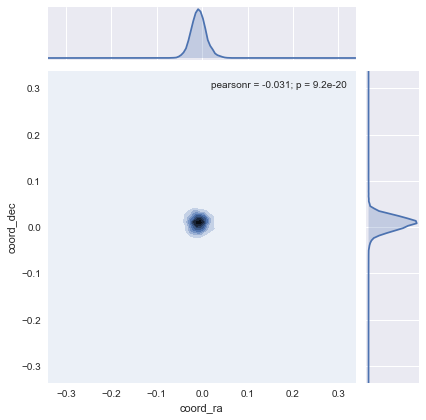

In [88]:
xx, yy = primaryI1['coord_ra'] - primaryI1['RA'], primaryI1['coord_dec'] - primaryI1['DEC'] 
xx, yy = xx*3600.0, yy*3600.0

sns.jointplot(x=xx, y=yy, kind="kde")

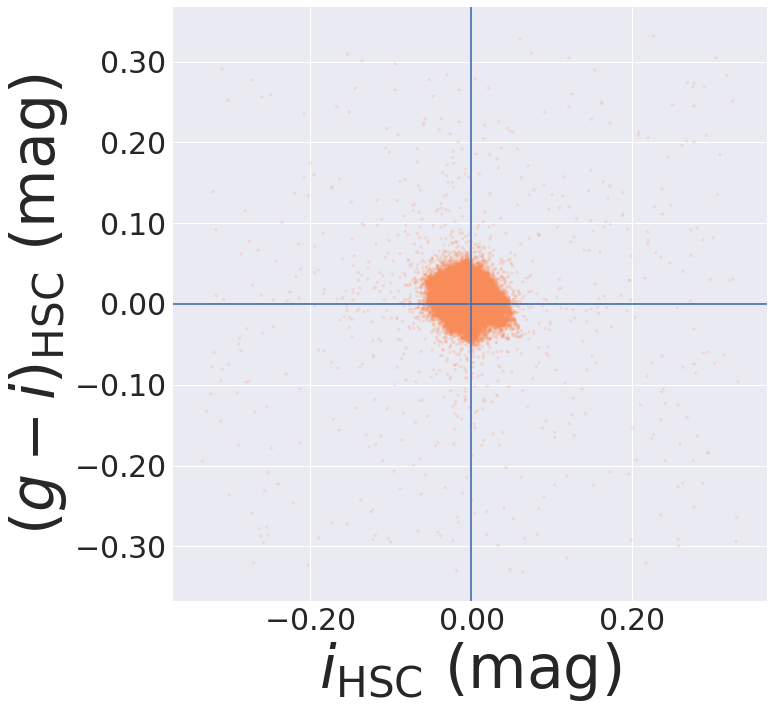

In [85]:
xx, yy = primaryI1['coord_ra'] - primaryI1['RA'], primaryI1['coord_dec'] - primaryI1['DEC'] 
xx, yy = xx*3600.0, yy*3600.0

#-----------------------------------------------------------------#
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.17, right=0.995, 
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

#-----------------------------------------------------------------#
# logM100 - C82
ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=30, ylabel=30, border=0,
                    majorTickL=0, minorTickL=0,
                    majorTickW=0, minorTickW=0,
                    xtickFormat='$\mathrm{%5.2f}$', 
                    ytickFormat='$\mathrm{%5.2f}$')

ax1.scatter(xx, yy, marker='o', edgecolor='none', cmap=ORG, s=10,
            c=ORG(0.5), alpha=0.20, rasterized=True)

# Scaling Relations
ax1.set_rasterization_zorder(0) 
#lin = np.linspace(-5.0, 5.0, 100)
#ax1.plot(lin, lin, linestyle='--', color=BLK(0.95), alpha=0.7, 
#         linewidth=8.0, zorder=2, dashes=(30,6))

# X, Y Label
ax1.set_xlabel('$i_{\mathrm{HSC}} \ (\mathrm{mag})$', size=60)
ax1.set_ylabel('$(g-i)_{\mathrm{HSC}}\ (\mathrm{mag})$', size=60)

ax1.axhline(0.0)
ax1.axvline(0.0)
# X, Y limits
#ax1.set_xlim(-0.01, 0.01)
#ax1.set_ylim(-0.01, 0.01)

#ax1.legend(loc=(0.03, 0.74),
#           shadow=True, fancybox=True, 
#           numpoints=1, fontsize=38, scatterpoints=1, 
#           markerscale=1.8, borderpad=0.3, handletextpad=0.5)

#-----------------------------------------------------------------#
#fig.savefig(os.path.join(figDir, 'redbcg_mass_r50.pdf'), dpi=150)

plt.show()

# Flux accuracy

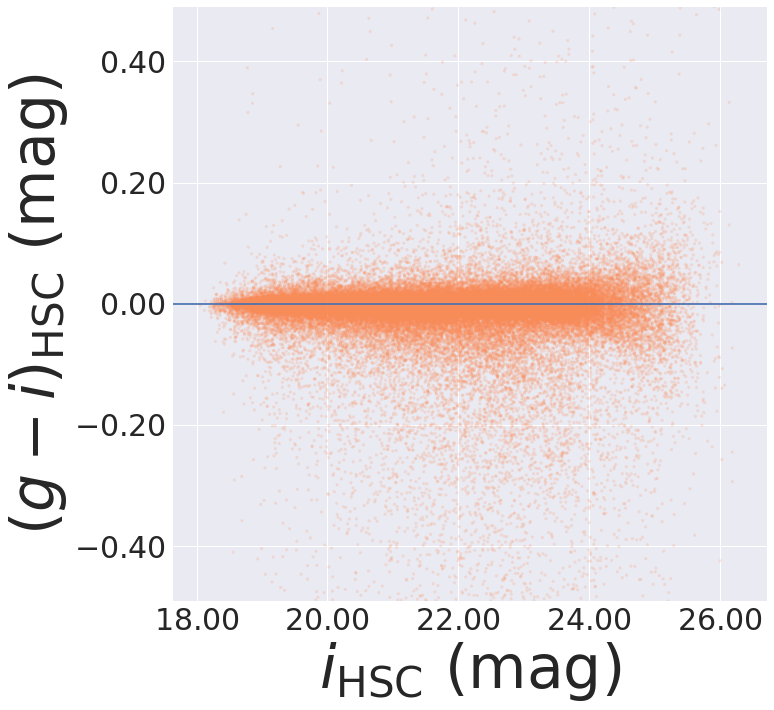

In [99]:
xx, yy = primaryI1['mag_I'], primaryI1['mag_I'] - primaryI1['force.mag.psf'] + primaryI1['force.mag.psf.apcorr']

#-----------------------------------------------------------------#
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.17, right=0.995, 
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

#-----------------------------------------------------------------#
# logM100 - C82
ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=30, ylabel=30, border=0,
                    majorTickL=0, minorTickL=0,
                    majorTickW=0, minorTickW=0,
                    xtickFormat='$\mathrm{%5.2f}$', 
                    ytickFormat='$\mathrm{%5.2f}$')

ax1.scatter(xx, yy, marker='o', edgecolor='none', cmap=ORG, s=10,
            c=ORG(0.5), alpha=0.20, rasterized=True)

# Scaling Relations
ax1.set_rasterization_zorder(0) 
#lin = np.linspace(-5.0, 5.0, 100)
#ax1.plot(lin, lin, linestyle='--', color=BLK(0.95), alpha=0.7, 
#         linewidth=8.0, zorder=2, dashes=(30,6))

# X, Y Label
ax1.set_xlabel('$i_{\mathrm{HSC}} \ (\mathrm{mag})$', size=60)
ax1.set_ylabel('$(g-i)_{\mathrm{HSC}}\ (\mathrm{mag})$', size=60)

ax1.axhline(0.0)
# X, Y limits
#ax1.set_xlim(-0.01, 0.01)
ax1.set_ylim(-0.49, 0.49)

#ax1.legend(loc=(0.03, 0.74),
#           shadow=True, fancybox=True, 
#           numpoints=1, fontsize=38, scatterpoints=1, 
#           markerscale=1.8, borderpad=0.3, handletextpad=0.5)

#-----------------------------------------------------------------#
#fig.savefig(os.path.join(figDir, 'redbcg_mass_r50.pdf'), dpi=150)

plt.show()

/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


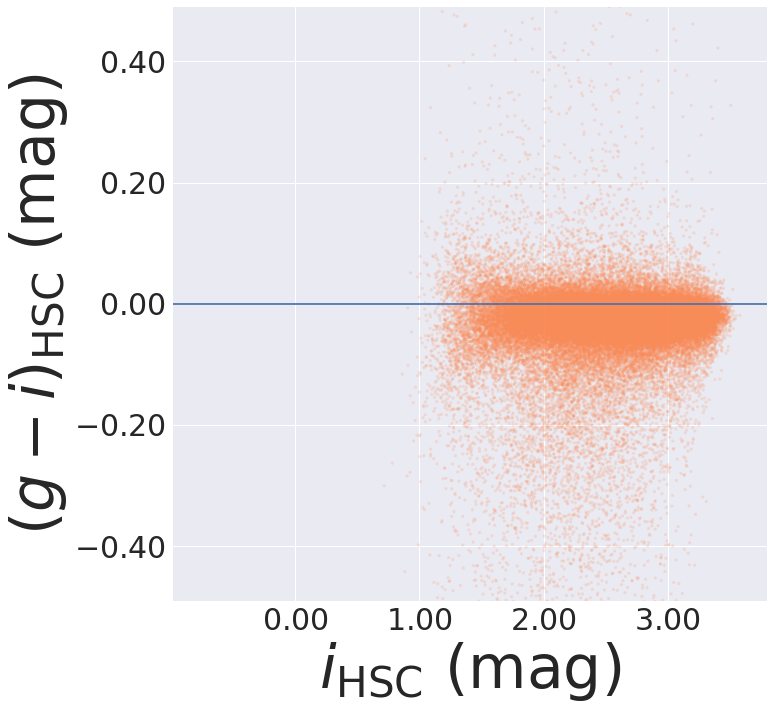

In [97]:
xx, yy = np.log10(primaryI1['force.flux.psf'] / primaryI1['force.flux.psf.err']), primaryI1['mag_I'] - primaryI1['force.mag.psf'] 

#-----------------------------------------------------------------#
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.17, right=0.995, 
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

#-----------------------------------------------------------------#
# logM100 - C82
ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=30, ylabel=30, border=0,
                    majorTickL=0, minorTickL=0,
                    majorTickW=0, minorTickW=0,
                    xtickFormat='$\mathrm{%5.2f}$', 
                    ytickFormat='$\mathrm{%5.2f}$')

ax1.scatter(xx, yy, marker='o', edgecolor='none', cmap=ORG, s=10,
            c=ORG(0.5), alpha=0.20, rasterized=True)

# Scaling Relations
ax1.set_rasterization_zorder(0) 
#lin = np.linspace(-5.0, 5.0, 100)
#ax1.plot(lin, lin, linestyle='--', color=BLK(0.95), alpha=0.7, 
#         linewidth=8.0, zorder=2, dashes=(30,6))

# X, Y Label
ax1.set_xlabel('$i_{\mathrm{HSC}} \ (\mathrm{mag})$', size=60)
ax1.set_ylabel('$(g-i)_{\mathrm{HSC}}\ (\mathrm{mag})$', size=60)

ax1.axhline(0.0)
# X, Y limits
#ax1.set_xlim(-0.01, 0.01)
ax1.set_ylim(-0.49, 0.49)

#ax1.legend(loc=(0.03, 0.74),
#           shadow=True, fancybox=True, 
#           numpoints=1, fontsize=38, scatterpoints=1, 
#           markerscale=1.8, borderpad=0.3, handletextpad=0.5)

#-----------------------------------------------------------------#
#fig.savefig(os.path.join(figDir, 'redbcg_mass_r50.pdf'), dpi=150)

plt.show()

# Color Accuracy